In [1]:
import sys

import numpy as np
import matplotlib

%matplotlib inline
print(f"Python version: {sys.version}\nNumpy version: {np.__version__}\nMatplotlib version: {matplotlib.__version__}")

Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Numpy version: 1.26.4
Matplotlib version: 3.8.0


# Problem 1

## Given problem setup

In [2]:
import time

import torch
import numpy as np
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

alpha = 0.1
K = 1000
B = 128
N = 512

def f_true(x) :
    return (x-2) * np.cos(x*4)

## Create training data

In [3]:
torch.manual_seed(0)
X_train = torch.normal(0.0, 1.0, (N,))
y_train = f_true(X_train)
X_val = torch.normal(0.0, 1.0, (N//5,))
y_val = f_true(X_val)

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=B, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=B)

## Create MLP, train and display results

In [4]:
# Create MLP as defined in problem
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # create linear layers with (n0, n1, n2, n3) = (1, 64, 64, 1)
        self.l1 = nn.Linear(1, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 1)

        # initialise weights and biases as given in problem
        for layer in [self.l1, self.l2, self.l3]:
            nn.init.normal_(layer.weight.data, 0, 1)
            nn.init.constant_(layer.bias.data, 0.03)

    def forward(self, x):
        x = nn.functional.sigmoid(self.l1(x))
        x = nn.functional.sigmoid(self.l2(x))
        x = self.l3(x)  # no activation function on last layer since we want direct outputs
        return x

In [5]:
def train_model(loss_function=nn.MSELoss()) -> MLP:
    model = MLP()
    optimizer = torch.optim.SGD(model.parameters(), lr=alpha)  # use stochastic gradient descent with learning rate alpha
    
    start = time.time()
    for epoch_k in range(K):
        print(f"Starting epoch {epoch_k+1:>5}/{K}", end='\r')
        for xs, ys in train_dataloader:
            optimizer.zero_grad()
    
            train_loss = loss_function(model(xs), ys.float())
            train_loss.backward()
    
            optimizer.step()
    end = time.time()
    print(f"Total training time: {end-start}")
    
    return model

trained_model = train_model()

Total training time: 2.7376530170440674


Mean loss on test x set (x_val): 0.0844


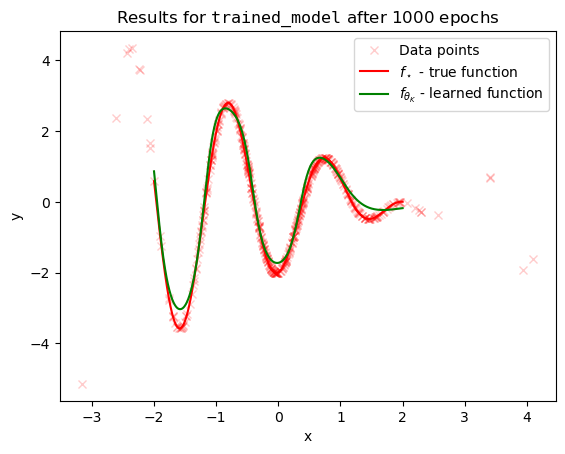

In [6]:
def show_results(model, y_train, loss_function=nn.MSELoss(), ax=None, title=''):
    test_loss = 0
    for xs, ys in test_dataloader:
        test_loss += loss_function(model(xs), ys.float()).float()
    print(f"Mean loss on test x set (x_val): {test_loss/len(test_dataloader):.4f}")

    if ax is None:
        plt.figure()
        ax = plt.gca()
        
    with torch.no_grad():
        xx = torch.linspace(-2,2,1024).unsqueeze(1)
        ax.plot(X_train, y_train, 'rx', label='Data points', alpha=0.2)
        ax.plot(xx, f_true(xx), 'r', label='$f_\\star$ - true function')
        ax.plot(xx, model(xx), 'g', label='$f_{\\theta_K}$ - learned function')

    if not title:
        # use the name of the variable passed to show_results in the title
        model_var_name = [name for name, var in globals().items() if var is model][0].replace("_", "\\_")
        title = f'Results for $\\mathtt{{{model_var_name}}}$ after {K} epochs'
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
show_results(trained_model, y_train)
plt.legend()
plt.show()

# Problem 2

## How many parameters?

The previous problem has 
$(1\times64 + 64) + (64\times64 + 64) + (64\times1 + 1) = 4353$
parameters where the brackets delineate the of parameters each layer.

We can actually count these programmatically (following the above logic or using `pytorch` directly):

In [7]:
# total_trainable_parameters = 0
# for layer_name in ['l1', 'l2', 'l3']:
#     # e.g.
#     # trained_model.l1.weight.size()
#     total_trainable_parameters += torch.numel(trained_model.__getattr__(layer_name).weight)
#     total_trainable_parameters += torch.numel(trained_model.__getattr__(layer_name).bias)

# requires_grad=True indicates that it is affected by the back propagation optimisation, i.e. is trainable
total_trainable_parameters = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)

print(f'Number of trainable parameters, p={total_trainable_parameters} (N={N})')

Number of trainable parameters, p=4353 (N=512)


## Set up different problem data

In [8]:
torch.manual_seed(0)
X_train = torch.normal(0.0, 1.0, (N,))
y_train_noisy = f_true(X_train) + torch.normal(0, 0.5, X_train.shape)
X_val = torch.normal(0.0, 1.0, (N//5,))
y_val = f_true(X_val)

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train_noisy.unsqueeze(1)), batch_size=B, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=B)
new_trained_model = train_model()

Total training time: 2.585700273513794


Results for new model
Mean loss on test x set (x_val): 0.0517
Results for old model
Mean loss on test x set (x_val): 0.0728


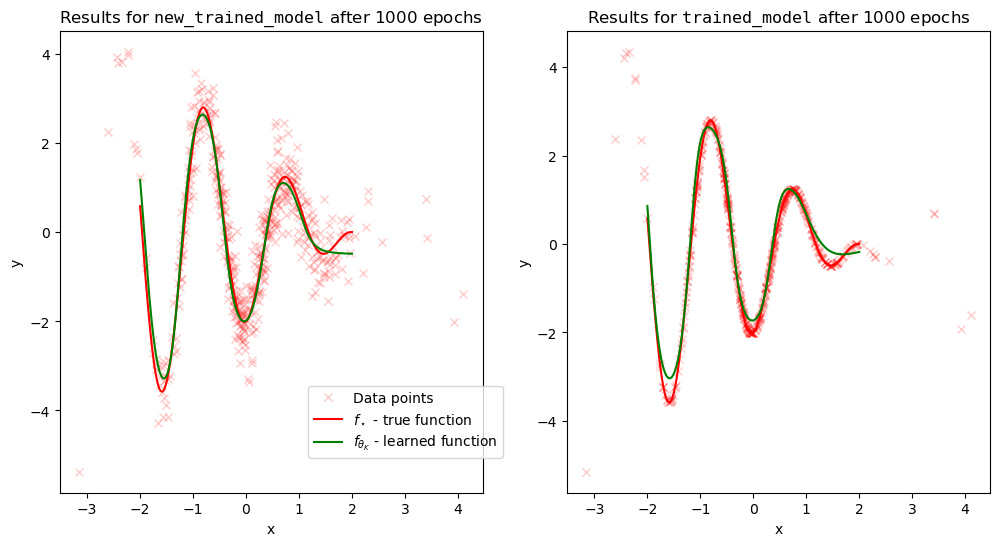

In [9]:
# create axes to show both plots for the new and old model side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
print("Results for new model")
show_results(new_trained_model, y_train_noisy, ax=ax1)
print("Results for old model")
show_results(trained_model, y_train, ax=ax2)

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, 0.3))
plt.show()

The function results are slightly better with the new model (trained on the y data with noise added), with the $f_{\theta_K}$ matching $f_\star$ more closely especially on the downward curves at $x=-1.5, 0, 1.5$. 
It does perform very slightly worse than the original model on the upper peaks of the true function.
However, its mean loss on the test data is slightly better, potentially indicating that the new model is more robust and has overfit less.